In [14]:
%matplotlib inline
import os
import tensorflow as tf
from functools import reduce
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import scipy.misc
from libs import utils
import scipy.io
import warnings
warnings.filterwarnings('ignore')

這是助教Notebook中的style transfer程式。

In [15]:
content_directory = 'contents/'
style_directory = 'styles/'
output_directory = 'image_output/'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)
checkpoint_directory = 'checkpoint_output/'
if not os.path.exists(checkpoint_directory):
  os.makedirs(checkpoint_directory) 
content_path = os.path.join(content_directory, 'wonder-woman.jpg')
style_path = os.path.join(style_directory, 'starry-night.jpg')
output_path = os.path.join(output_directory, 'wonder-woman-starry-night-iteration-1000.jpg')
# please notice that the checkpoint_images_path has to contain %s in the file_name
checkpoint_path = os.path.join(checkpoint_directory, 'wonder-woman-starry-night-iteration-1000-%s.jpg')

In [16]:
VGG_MEAN = [103.939, 116.779, 123.68]
VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
'relu5_3', 'conv5_4', 'relu5_4'
)
def net_preloaded(input_image, pooling):
  data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
  net = {}
  current = input_image
  for i, name in enumerate(VGG19_LAYERS):
    kind = name[:4]
    if kind == 'conv':
      kernels = get_conv_filter(data_dict, name)
      # kernels = np.transpose(kernels, (1, 0, 2, 3))
      bias = get_bias(data_dict, name)
      # matconvnet: weights are [width, height, in_channels, out_channels]
      # tensorflow: weights are [height, width, in_channels, out_channels]
      # bias = bias.reshape(-1)
      current = conv_layer(current, kernels, bias)
    elif kind == 'relu':
      current = tf.nn.relu(current)
    elif kind == 'pool':
      current = pool_layer(current, pooling)
    net[name] = current
  assert len(net) == len(VGG19_LAYERS)
  return net

def conv_layer(input, weights, bias):
  conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)

def pool_layer(input, pooling):
  if pooling == 'avg':
    return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
  else:
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

def preprocess(image):
  return image - VGG_MEAN

# remember to unprocess it before you plot it out and save it.
def unprocess(image):
  return image + VGG_MEAN

def get_conv_filter(data_dict, name):
  return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
  return tf.constant(data_dict[name][1], name="biases")

In [17]:
# feel free to try different layers
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat', 
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2, 
            style_layer_weight_exp=1,style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):
    
    
  shape = (1,) + content.shape                             #content image shape : (1,433,770,3)
  style_shapes = [(1,) + style.shape for style in styles]  #style image shape : (1,600,800,3)
  content_features = {}
  style_features = [{} for _ in styles]

    
  # scale the importance of each style layers according to their depth. 
  # (deeper layers are more important if style_layers_weights > 1 (default = 1))
  layer_weight = 1.0
  style_layers_weights = {}                                # weight for different network layers
  for style_layer in STYLE_LAYERS:                                    
    style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
    layer_weight *= style_layer_weight_exp                 # 1.0

        
  # normalize style layer weights
  layer_weights_sum = 0
  for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
    layer_weights_sum += style_layers_weights[style_layer] # 5.0
  for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum

        
  # FEATURE MAPS FROM CONTENT IMAGE
  # compute the feature map of the content image by feeding it into the network
  #the output net contains the features of each content layer
  g = tf.Graph()
  with g.as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)

    net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
    content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
    for layer in CONTENT_LAYERS:                    #'relu4_2', 'relu5_2'
      content_features[layer] = net[layer].eval(feed_dict={image: content_pre})  

            
  # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
  # compute style features of the style image by feeding it into the network
  # and calculate the gram matrix
  for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
      image = tf.placeholder('float', shape=style_shapes[i])
      net = net_preloaded(image, pooling)                           
      style_pre = np.array([preprocess(styles[i])])
      for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
        features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
        features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
        gram = np.matmul(features.T, features) / features.size    # (64,64)
        style_features[i][layer] = gram

                
  # make stylized image using backpropogation
  with tf.Graph().as_default():

    # Generate a random image (the output image) with the same shape as the content image
    initial = tf.random_normal(shape) * 0.256  
    image = tf.Variable(initial)
    net = net_preloaded(image, pooling)
    

    # CONTENT LOSS
    # we can adjust the weight of each content layers
    # content_weight_blend is the ratio of two used content layers in this example
    content_layers_weights = {}
    content_layers_weights['relu4_2'] = content_weight_blend 
    content_layers_weights['relu5_2'] = 1.0 - content_weight_blend      

    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
      # Use MSE as content losses
      # content weight is the coefficient for content loss
      content_losses.append(content_layers_weights[content_layer] * content_weight * 
              (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
              content_features[content_layer].size))
    content_loss += reduce(tf.add, content_losses)



    # STYLE LOSS
    # We can specify different weight for different style images
    # style_layers_weights => weight for different network layers
    # style_blend_weights => weight between different style images

    if style_blend_weights is None:
      style_blend_weights = [1.0/len(styles) for _ in styles]
    else:
      total_blend_weight = sum(style_blend_weights)
      # normalization
      style_blend_weights = [weight/total_blend_weight
                             for weight in style_blend_weights]


    style_loss = 0
    # iterate to calculate style loss with multiple style images
    for i in range(len(styles)):
      style_losses = []
      for style_layer in STYLE_LAYERS:             # e.g. relu1_1
        layer = net[style_layer]                   # relu1_1 of output image:(1,433,770,64)
        _, height, width, number = map(lambda i: i.value, layer.get_shape())  
        size = height * width * number
        feats = tf.reshape(layer, (-1, number))    # (333410,64)

        # Gram matrix for the features in relu1_1 of the output image.
        gram = tf.matmul(tf.transpose(feats), feats) / size
        # Gram matrix for the features in relu1_1 of the style image
        style_gram = style_features[i][style_layer]   

        # Style loss is the MSE for the difference of the 2 Gram matrices
        style_losses.append(style_layers_weights[style_layer] * 2 * 
                            tf.nn.l2_loss(gram - style_gram) / style_gram.size)
      style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)


    # TOTAL VARIATION LOSS  
    # Total variation denoising to do smoothing; cost to penalize neighboring pixel
    # not used by the original paper by Gatys et al
    # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
    # image representations by inverting them."
    # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
      (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
          tv_y_size) +
      (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
          tv_x_size))


    #OVERALL LOSS
    loss = content_loss + style_loss + tv_loss

    train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

    def print_progress():
      print('     iteration: %d\n' % i)
      print('  content loss: %g\n' % content_loss.eval())
      print('    style loss: %g\n' % style_loss.eval())
      print('       tv loss: %g\n' % tv_loss.eval())
      print('    total loss: %g\n' % loss.eval())

    def imsave(path, img):
      img = np.clip(img, 0, 255).astype(np.uint8)
      Image.fromarray(img).save(path, quality=95)

    
    
    # TRAINING
    best_loss = float('inf')
    best = None
    
    with tf.Session() as sess:
        
      sess.run(tf.global_variables_initializer())
    
      if (print_iterations and print_iterations != 0):
        print_progress()
        
      for i in range(iterations):

        train_step.run()

        last_step = (i == iterations - 1)
        if last_step or (print_iterations and i % print_iterations == 0):
          print_progress()

        # store output and checkpoint images
        if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
          this_loss = loss.eval()
          if this_loss < best_loss:
            best_loss = this_loss
            best = image.eval()

          img_out = unprocess(best.reshape(shape[1:]))

          output_file = None
          if not last_step:
            if checkpoint_path:
                output_file = checkpoint_path % i
          else:
            output_file = output_path

          if output_file:
            imsave(output_file, img_out)
            
  print("finish stylizing.")



def _tensor_size(tensor):
  from operator import mul
  return reduce(mul, (d.value for d in tensor.get_shape()), 1)

左圖是我所用的content image，右圖則是我選擇用的style image。

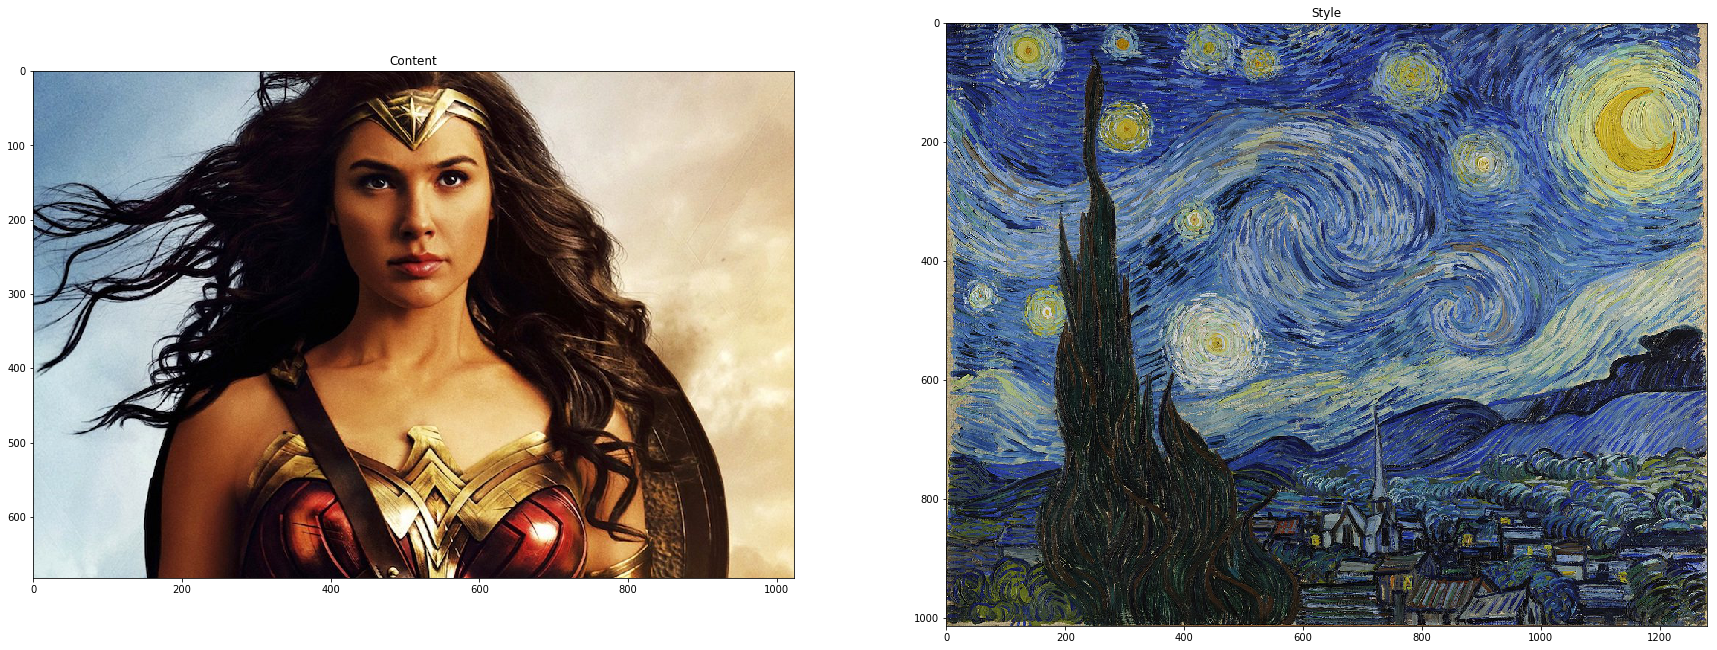

In [18]:
content_image = utils.loadImage(content_directory, 'wonder-woman.jpg')
style_image = utils.loadImage(style_directory, 'starry-night.jpg')
utils.showImage(content_image, style_image)

這個部分先用助教最原始設好的的參數run一次。

In [19]:
checkpoint_path=None
output_path = output_directory + 'wonder-woman-starry-night-tvweight-100.jpg'

stylize(content_image, [style_image], iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2, 
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 494443

    style loss: 2.32223e+06

       tv loss: 26.2044

    total loss: 2.8167e+06

     iteration: 0

  content loss: 474450

    style loss: 2.02338e+06

       tv loss: 15845.9

    total loss: 2.51368e+06

     iteration: 100

  content loss: 164661

    style loss: 36454

       tv loss: 50606.4

    total loss: 251721

     iteration: 200

  content loss: 142676

    style loss: 37323.5

       tv loss: 45215.3

    total loss: 225215

     iteration: 300

  content loss: 141559

    style loss: 34291.8

       tv loss: 44425.2

    total loss: 220275

     iteration: 400

  content loss: 140122

    style loss: 36778.3

       tv loss: 44119.2

    total loss: 221020

     iteration: 500

  content loss: 138048

    style loss: 35780.8

       tv loss: 43183.8

    total loss: 217013

     iteration: 600

  content loss: 134631

    style loss: 39215.1

       tv loss: 43110.1

    total loss: 216956

     iteration: 700

  content loss: 

# Report

### 1. Change the weight for style, content, and denoising.

#### 1. 比較結果的部分，除了要比較的參數，其他先固定(照助教原本的default值)，針對content的weight部分我試了以下的組合:
    i. content_weight = 5e5    
    ii. content_weight = 5e0    
    iii. content_weight = 5e-5
    
   ##### (由上至下的content_weight分別為5e5、5e0、5e-5)

<img src="image_output/content_weight=5e5.jpg" width = "50%" />
<img src="image_output/style=5e2.jpg" width = "50%" />
<img src="image_output/content_weight=5e-5.jpg" width = "50%" />

比較weight of content的部分可以看到weight=5e5時，比weight=5e0時更偏向content image；而相反的weigth=5e-5時，比weight=5e0時更看不出content，反而都是style image的感覺。

#### 2. 針對style_layer_weight_exp的部分我也做了一點嘗試:
    i. style_layer_weight_exp=0.1
    ii. style_layer_weight_exp=0.3    
    iii. style_layer_weight_exp=1    
    iv. style_layer_weight_exp=1.2    
    v. style_layer_weight_exp=2
   ##### (由上道下分別為i., ii., iii., iv., v.)

<img src="image_output/style_layer_weight_exp=0.1.jpg" width = "50%" />
<img src="image_output/style_layer_weight_exp=0.3.jpg" width = "50%" />
<img src="image_output/style=5e2.jpg" width = "50%" />
<img src="image_output/style_layer_weight_exp=1.2.jpg" width = "50%" />
<img src="image_output/style_layer_weight_exp=2.jpg" width = "50%" />

這個部分會嘗試這麼多種style_layer_weight_exp的原因是因為一開始選1.2、1、0.3時覺得結果沒有很清楚，因此又做了2和0.1來進行比較，這樣的結果我猜可能是因為如果抽前幾層比例比較重的話，前幾層的特徵也許是偏向於小區塊邊緣的部分，所以不會有很明顯的style image的風格套進照片中；但如果抽後幾層的比例越來越重的話，比較深的layer可以學到不是邊緣而是偏向整體的特徵，看起來比較像真的是取style image的"風格"的感覺。

#### 3. 針對style_weight的部分我試了以下的組合:
    i. style_weight = 5e4  
    ii. style_weight = 5e2    
    iii. style_weight = 5e0    
   ##### (由上而下的style_weight分別為5e4、5e2、5e0)

<img src="image_output/style=5e4.jpg" width = "50%" />
<img src="image_output/style=5e2.jpg" width = "50%" />
<img src="image_output/style=5e0.jpg" width = "50%" />

由上方的圖可以發現，weight of style太大，會造成整張圖失去content，都是style image的特徵；而如果weight太小，會造成圖片偏向content image的內容，沒有成功轉換融合到style image的風格(和content_weight有種相反的趨勢)。

#### 4. 針對content_weight_blend的部分我也做了幾個實驗:
    i. content_weight_blend = 1
    ii. content_weight_blend = 0.5
    iii. content_weight_blend = 0
   ##### (由上而下分別為1、0.5、0)

<img src="image_output/style=5e2.jpg" width = "50%" />
<img src="image_output/content_weight_blend=0.5.jpg" width = "50%" />
<img src="image_output/content_weight_blend=0.jpg" width = "50%" />

content_weight_blend=1時，以code的內容來說，是學習content_layer較為前面那層的content，那麼內容就會偏向跟content image比較像一些；但content_weight_blend=1時，我們知道較深的layer會學較為整體的特徵，所以圖片中看起來也許它只學到哪個部分有東西(黑色部分)，其他的內容反而沒有詳細應該要保留的content。

#### 5. 針對denoising的部分，以下是我嘗試的組合:  
    i. tv_loss = 500    
    ii. tv_loss = 100    
    iii. tv_loss = 1
    
   ##### (由上到下圖的tv_loss分別為500、100、1)

<img src="image_output/tv_loss=500.jpg" width = "50%" />
<img src="image_output/style=5e2.jpg" width = "50%" />
<img src="image_output/tv_loss=1.jpg" width = "50%" />

觀察以上三張圖，仔細看特別是邊緣以及線條的部分，當tv_loss太小時，容易有noise；而當tv_loss較大時，的確有較為smoothing的感覺，整張照片看起來比較平滑、流暢。

### 2. Use other layers in the model.

#### 1. 我總共嘗試了三種不同組合的CONTENT_LAYER:
    i. Content_layer = "relu4_2", "relu5_2"
    ii. Content_layer = "relu1_2", "relu2_2"
    iii. Content_layer = "relu1_2", "relu2_2", "relu3_2", "relu4_2", "relu5_2"(此部分的content_layer_blend取每個layer的平均值)
   ##### (由上到下分別為i.、ii.、iii.)

<img src="image_output/c relu4_2+relu5_2.jpg" width = "50%" />

#### Loss:
     iteration: 0:
     {content loss: 247568, style loss: 2.32224e+06, tv loss: 26.1749,
         total loss: 2.56983e+06, relu4_2 247234.23, relu5_2 334.17972}
     iteration: 0:
     {content loss: 237771, style loss: 2.00519e+06, tv loss: 15500.5,
         total loss: 2.25846e+06, relu4_2 237442.28, relu5_2 328.95166}
     iteration: 100:
     {content loss: 108234, style loss: 22492.5, tv loss: 49639.2,
         total loss: 180365, relu4_2 108094.02, relu5_2 139.62033}
     iteration: 200:
     {content loss: 89904.7, style loss: 38117.9, tv loss: 43076.6,
         total loss: 171099, relu4_2 89793.45, relu5_2 111.26463}
     iteration: 300:
     {content loss: 85289.5, style loss: 20479.7, tv loss: 42279.8,
         total loss: 148049, relu4_2 85182.38, relu5_2 107.11877}
     iteration: 400:
     {content loss: 83449, style loss: 20746.5, tv loss: 41627.6,
         total loss: 145823, relu4_2 83345.38, relu5_2 103.59457}
     iteration: 500:
     {content loss: 81208.9, style loss: 21209.8,  tv loss: 41372.1,
         total loss: 143791, relu4_2 81108.18, relu5_2 100.673485}
     iteration: 600:
     {content loss: 80325.8, style loss: 25882.9, tv loss: 41389,
         total loss: 147598, relu4_2 80225.664, relu5_2 100.09867}
     iteration: 700:
     {content loss: 82351.6, style loss: 19523.2, tv loss: 41332,
         total loss: 143207, relu4_2 82251.266, relu5_2 100.35428}
     iteration: 800:
     {content loss: 81078.4, style loss: 20832.2, tv loss: 41049.9,
         total loss: 142960, relu4_2 80978.76, relu5_2 99.617134}
     iteration: 900:
     {content loss: 80772.7, style loss: 21422.6, tv loss: 40738,
         total loss: 142933, relu4_2 80673.87, relu5_2 98.824356}
     iteration: 999:
     {content loss: 80168.6, style loss: 21969.2, tv loss: 41255.1,
         total loss: 143393, relu4_2 80069.055, relu5_2 99.53089}

<img src="image_output/c relu1_2+relu2_2.jpg" width = "50%" />

#### Loss:
     iteration: 0:
     {content loss: 262413, style loss: 2.32224e+06, tv loss: 26.228,
         total loss: 2.58468e+06, relu1_2 151549.92, relu2_2 110863.32}
     iteration: 0:
     {content loss: 236826, style loss: 1.96004e+06, tv loss: 15105.9,
         total loss: 2.21197e+06, relu1_2 130157.62, relu2_2 106668.66}
     iteration: 100:
     {content loss: 103411, style loss: 25176.8, tv loss: 45653.8,
         total loss: 174241, relu1_2 54440.676, relu2_2 48970.234}
     iteration: 200
     {content loss: 87269.3, style loss: 24476.8, tv loss: 43543.9,
         total loss: 155290, relu1_2 43880.254, relu2_2 43389.01}
     iteration: 300
     {content loss: 82290.5, style loss: 28407.2, tv loss: 43134.6,
         total loss: 153832, relu1_2 40249.535, relu2_2 42040.957}
     iteration: 400
     {content loss: 84660.9, style loss: 26362.9, tv loss: 43786.1, 
         total loss: 154810, relu1_2 40161.316, relu2_2 44499.56}
     iteration: 500
     {content loss: 79675.1, style loss: 25410.1, tv loss: 42705.7,
         total loss: 147791, relu1_2 38239.633, relu2_2 41435.43}
     iteration: 600
     {content loss: 81658.7, style loss: 26856.4, tv loss: 43216.8,
         total loss: 151732, relu1_2 38431.242, relu2_2 43227.48}
     iteration: 700
     {content loss: 79992.2, style loss: 27038.4, tv loss: 42765.9,
         total loss: 149797, relu1_2 37837.16, relu2_2 42155.06}
     iteration: 800
     {content loss: 78399.4, style loss: 33573.7, tv loss: 43013.9,
         total loss: 154987, relu1_2 37305.87, relu2_2 41093.504}
     iteration: 900
     {content loss: 80368.8, style loss: 28287.1, tv loss: 42917.7,
         total loss: 151574, relu1_2 37787.715, relu2_2 42581.133}
     iteration: 999
     {content loss: 79362.6, style loss: 26650.5, tv loss: 42863.4,
         total loss: 148876, relu1_2 37484.63, relu2_2 41877.934}

<img src="image_output/c relu1~5.jpg" width = "50%" />

#### Loss:
     iteration: 0:
     {content loss: 230980, style loss: 2.32223e+06, tv loss: 26.1696, total loss: 2.55324e+06,
         relu1_2 60619.234, relu2_2 44344.555, relu3_2 26986.477, relu4_2 98896.55, relu5_2 133.67099}
     iteration: 0:
     {content loss: 218707, style loss: 1.98455e+06, tv loss: 15440.8, total loss: 2.2187e+06,
         relu1_2 54072.902, relu2_2 44717.46, relu3_2 24627.965, relu4_2 95156.53, relu5_2 131.71251}
     iteration: 100:
     {content loss: 120799, style loss: 21662.2, tv loss: 47459.6, total loss: 189921, 
         relu1_2 31696.838, relu2_2 28586.463, relu3_2 12951.851, relu4_2 47499.74, relu5_2 63.77351}
     iteration: 200:
     {content loss: 101310, style loss: 20456.7, tv loss: 43070.1, total loss: 164837,
         relu1_2 26176.096, relu2_2 22865.66, relu3_2 11109.667, relu4_2 41105.266, relu5_2 53.187782}
     iteration: 300:
     {content loss: 99077.7, style loss: 19302.2, , tv loss: 42923.4, total loss: 161303,
         relu1_2 24368.588, relu2_2 22451.988, relu3_2 11040.238, relu4_2 41163.74, relu5_2 53.120342}
     iteration: 400:
     {content loss: 96080, style loss: 20808.4, tv loss: 42880.3, total loss: 159769,
         relu1_2 22872.387, relu2_2 21709.629, relu3_2 10842.333, relu4_2 40602.086, relu5_2 53.53333}
     iteration: 500:
     {content loss: 94929.3, style loss: 19271.4, tv loss: 42425.4, total loss: 156626,
         relu1_2 21833.121, relu2_2 21778.72, relu3_2 10825.317, relu4_2 40439.703, relu5_2 52.46628}
     iteration: 600:
     {content loss: 93037.6, style loss: 22381.1, tv loss: 43137.1, total loss: 158556, 
         relu1_2 21097.53, relu2_2 21669.143, relu3_2 10669.747, relu4_2 39547.98, relu5_2 53.205044}
     iteration: 700:
     {content loss: 92068.3, style loss: 20290.3, tv loss: 42178.4, total loss: 154537,
         relu1_2 20580.533, relu2_2 21179.512, relu3_2 10579.542, relu4_2 39676.82, relu5_2 51.91563}
     iteration: 800:
     {content loss: 92249.3, style loss: 19654.1, tv loss: 42300.7, total loss: 154204, 
         relu1_2 20355.889, relu2_2 21101.643, relu3_2 10622.979, relu4_2 40116.18, relu5_2 52.61089}
     iteration: 900:
     {content loss: 90749.1, style loss: 20803.5, tv loss: 41914.5, total loss: 153467,
         relu1_2 20318.74, relu2_2 21102.842, relu3_2 10495.848, relu4_2 38780.73, relu5_2 50.90172}
     iteration: 999:
     {content loss: 91137.8, style loss: 20195.6, tv loss: 41828.6, total loss: 153162,
         relu1_2 20219.354, relu2_2 21041.924, relu3_2 10535.585, relu4_2 39289.926, relu5_2 51.00101}

觀察上面的圖可以發現，如果是抽較為前面的layer，小區塊的輪廓會比較清楚，而如果是抽較為後面的layer，會變成大區塊的特徵比較明顯，則全抽的話則較為平均，但有些細微像是頭髮的部分會變成藍色。另外由於STYLE_LAYER的部分是以助教的預設，也就是抽"relu1_1"、"relu2_1"、"relu3_1"、"relu4_1"、"relu5_1"，所以當content layer只抽後面的時候，就會造成前面的部分是style image學習的比率比較重，因此會造成結果圖長的比較偏向style；但是當Content layer只抽前面的時候，會造成比較沒學到content深一點的layer所代表高階、整體一些的feature，所以content image中本身的輪廓則比較明顯。

#### 2. 以下是我所嘗試的STYLE_LAYERS組合:
    i. STYLE_LAYERS = "relu4_1"、"relu5_1"
    ii. STYLE_LAYERS = "relu1_1"、"relu2_1"
    iii. STYLE_LAYERS = "relu1_1"、"relu2_1"、"relu3_1"、"relu4_1"、"relu5_1"
   ##### (下圖的順序分別為i.、ii.、iii.)

<img src="image_output/s relu4_1+relu5_1.jpg" width = "50%" />

#### Loss:
    iteration: 0:
    {content loss: 99027.1, style loss: 3.16951e+06, tv loss: 26.2437, 
        total loss: 3.26856e+06, relu4_2 98893.43, relu5_2 133.67181}
     iteration: 0:
     {content loss: 95714.6, style loss: 2.77725e+06, tv loss: 15599.6, 
         total loss: 2.88856e+06, relu4_2 95582.766, relu5_2 131.83249}
     iteration: 100:
     {content loss: 75032.8, style loss: 18549, tv loss: 31309.3, 
         total loss: 124891, relu4_2 74921.19, relu5_2 111.56624}
     iteration: 200:
     {content loss: 60711.6, style loss: 8390.14, tv loss: 30310.6, 
         total loss: 99412.4, relu4_2 60623.844, relu5_2 87.73409}
     iteration: 300:
     {content loss: 54644.2, style loss: 11722.6, tv loss: 23898.8,
         total loss: 90265.5, relu4_2 54565.477, relu5_2 78.681915}
     iteration: 400:
     {content loss: 51767.8, style loss: 7170.81, tv loss: 22069.2, 
         total loss: 81007.8, relu4_2 51693.902, relu5_2 73.86148}
     iteration: 500:
     {content loss: 53790, style loss: 11572.8, tv loss: 34016.3, 
         total loss: 99379.1, relu4_2 53715.31, relu5_2 74.70863}
     iteration: 600:
     {content loss: 51549.5, style loss: 11429.5, tv loss: 29012,
         total loss: 91991.1, relu4_2 51478.617, relu5_2 70.92244}
     iteration: 700:
     {content loss: 48239.2, style loss: 9027.98, tv loss: 20626.2, 
     total loss: 77893.4, relu4_2 48172.418, relu5_2 66.79544}
     iteration: 800:
     {content loss: 48055.2, style loss: 9232.69, tv loss: 20508.1, 
         total loss: 77795.9, relu4_2 47988.836, relu5_2 66.325356}
     iteration: 900:
     {content loss: 47499.4, style loss: 13957.2, tv loss: 20419.2, 
         total loss: 81875.7, relu4_2 47434.074, relu5_2 65.29431}
     iteration: 999:
     {content loss: 48436.9, style loss: 7357.91, tv loss: 23732.6,
     total loss: 79527.4, relu4_2 48370.29, relu5_2 66.56159}
     
<img src="image_output/s relu1_1+relu2_1.jpg" width = "50%" />

#### Loss:
     iteration: 0:
     {content loss: 99025.4, style loss: 2.45565e+06, tv loss: 26.186, 
        total loss: 2.5547e+06, relu4_2 98891.695, relu5_2 133.66884}
     iteration: 0:
     {content loss: 93908.8, style loss: 2.05032e+06, tv loss: 15939.8,
         total loss: 2.16017e+06, relu4_2 93777.79, relu5_2 131.0315}
     iteration: 100:
     {content loss: 38613.5, style loss: 18490.6, tv loss: 47377.3, 
         total loss: 104481, relu4_2 38564.742, relu5_2 48.714935}
     iteration: 200:
     {content loss: 22613.7, style loss: 10231.4, tv loss: 45093.3, 
         total loss: 77938.4, relu4_2 22586.963, relu5_2 26.722486}
     iteration: 300:
     {content loss: 18803.9, style loss: 9101.21, tv loss: 44455.2,
         total loss: 72360.3, relu4_2 18782.225, relu5_2 21.648773}
     iteration: 400:
     {content loss: 17268.4, style loss: 8770.62, tv loss: 44150.6, 
         total loss: 70189.6, relu4_2 17248.777, relu5_2 19.603483}
     iteration: 500:
     {content loss: 16407.9, style loss: 8642.97, tv loss: 43946.5, 
         total loss: 68997.4, relu4_2 16389.55, relu5_2 18.38097}
     iteration: 600:
     {content loss: 15853.7, style loss: 8605.74, tv loss: 43816.2, 
         total loss: 68275.6, relu4_2 15836.074, relu5_2 17.591295}
     iteration: 700:
     {content loss: 15507.5, style loss: 8608.05, tv loss: 43716.7,
         total loss: 67832.2, relu4_2 15490.362, relu5_2 17.119991}
     iteration: 800:
     {content loss: 15335.8, style loss: 8618.82, tv loss: 43650.7,
         total loss: 67605.3, relu4_2 15318.905, relu5_2 16.851727}
     iteration: 900:
     {content loss: 15121.6, style loss: 8627.98, tv loss: 43607.4,
         total loss: 67357, relu4_2 15104.959, relu5_2 16.6583}
     iteration: 999:
     {content loss: 15055, style loss: 8621.68, tv loss: 43571.3, 
         total loss: 67247.9, relu4_2 15038.42, relu5_2 16.567017}

<img src="image_output/c relu4_2+relu5_2.jpg" width = "50%" />

#### Loss:
     iteration: 0:
     {content loss: 247568, style loss: 2.32224e+06, tv loss: 26.1749,
         total loss: 2.56983e+06, relu4_2 247234.23, relu5_2 334.17972}
     iteration: 0:
     {content loss: 237771, style loss: 2.00519e+06, tv loss: 15500.5,
         total loss: 2.25846e+06, relu4_2 237442.28, relu5_2 328.95166}
     iteration: 100:
     {content loss: 108234, style loss: 22492.5, tv loss: 49639.2,
         total loss: 180365, relu4_2 108094.02, relu5_2 139.62033}
     iteration: 200:
     {content loss: 89904.7, style loss: 38117.9, tv loss: 43076.6,
         total loss: 171099, relu4_2 89793.45, relu5_2 111.26463}
     iteration: 300:
     {content loss: 85289.5, style loss: 20479.7, tv loss: 42279.8,
         total loss: 148049, relu4_2 85182.38, relu5_2 107.11877}
     iteration: 400:
     {content loss: 83449, style loss: 20746.5, tv loss: 41627.6,
         total loss: 145823, relu4_2 83345.38, relu5_2 103.59457}
     iteration: 500:
     {content loss: 81208.9, style loss: 21209.8,  tv loss: 41372.1,
         total loss: 143791, relu4_2 81108.18, relu5_2 100.673485}
     iteration: 600:
     {content loss: 80325.8, style loss: 25882.9, tv loss: 41389,
         total loss: 147598, relu4_2 80225.664, relu5_2 100.09867}
     iteration: 700:
     {content loss: 82351.6, style loss: 19523.2, tv loss: 41332,
         total loss: 143207, relu4_2 82251.266, relu5_2 100.35428}
     iteration: 800:
     {content loss: 81078.4, style loss: 20832.2, tv loss: 41049.9,
         total loss: 142960, relu4_2 80978.76, relu5_2 99.617134}
     iteration: 900:
     {content loss: 80772.7, style loss: 21422.6, tv loss: 40738,
         total loss: 142933, relu4_2 80673.87, relu5_2 98.824356}
     iteration: 999:
     {content loss: 80168.6, style loss: 21969.2, tv loss: 41255.1,
         total loss: 143393, relu4_2 80069.055, relu5_2 99.53089}

上面三張圖差異滿大的，這邊實驗的CONTENT_LAYER也是用助教所default的層數，都是抽後面兩層，而第一張圖是抽style後面的layer，可以明顯看到整個風格的部分都變成content image和style image的融合，並沒有保有完整的皮膚等等；第二張圖是抽style前面的layer，因此可以發現整個風格是偏向content image的(因為default是抽content後面的layers，學習到content image中較為高階的特徵)；第三張圖style是淺到深的layer都有抽，因此可以發現跟只抽後面layers的圖相比，還保有style image中低階的邊緣紋路特徵。